In [91]:
import os
import json
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

In [ ]:
if 'google.colab' in sys.modules:  # colab環境
  # コンペごとに要書き換え
  !mkdir m5-forecasting-accuracy
  !mkdir m5-forecasting-accuracy/input/

  from google.colab import drive
  drive.mount('/content/drive')
  INPUT = Path("/content/m5-forecasting-accuracy/input") # Inputのパスを指定

  # Kaggle APIを使うための準備
  f = open("/content/drive/MyDrive/Kaggle/kaggle.json", 'r')
  json_data = json.load(f) #JSON形式で読み込む
  os.environ['KAGGLE_USERNAME'] = json_data['username']
  os.environ['KAGGLE_KEY'] = json_data['key']

  !pip install kaggle
  !kaggle competitions download -c m5-forecasting-accuracy -p m5-forecasting-accuracy/input # コンペごとに要書き換え

elif 'kaggle_web_client' in sys.modules:  # kaggle環境
  INPUT = Path("../input/")

# データの外観確認

In [6]:
df_calendar = pd.read_csv(str(INPUT)+'/calendar.csv')
df_prices = pd.read_csv(str(INPUT)+'/sell_prices.csv.zip')
df_train = pd.read_csv(str(INPUT)+'/sales_train_validation.csv.zip')
df_train_evaluation = pd.read_csv(str(INPUT)+'/sales_train_evaluation.csv.zip')
df_sbm = pd.read_csv(str(INPUT)+'/sample_submission.csv.zip')

## Trainデータ(validation)

In [7]:
df_train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,1,7,7,3,6,3,3,7,12,4,2,7,5,12,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,1,0,0,0,0,3,1,1,1,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,4,7,2,3,5,6,3,4,1,2,5,1,2,2,2,...,1,1,2,0,0,2,0,0,0,2,0,1,1,0,0,0,0,1,1,2,1,4,0,0,2,2,4,0,0,0,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,2,1,1,2,4,3,0,0,0,0,0,1,1,2,1,1,1,1,2,0,1,0,3,0,0,1,0,0,1,0,3,1,3


### sales_train_validationの説明
| カラム名 | 説明 |
| - | - |
| id | ite_id + store_id  |
| item_id | 商品のid |
| dept_id | 商品のカテゴリー（詳細） |
| cat_id | 商品のカテゴリーのid |
| store_id | 店のid |
| state_id | 場所のid |
| d_1など | 日付と売り上げと個数 |

In [9]:
print('-----dept_id-----')
print(df_train['dept_id'].value_counts())
print('-----store_id-----')
print(df_train['store_id'].value_counts())

-----dept_id-----
FOODS_3        8230
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
HOBBIES_1      4160
FOODS_2        3980
FOODS_1        2160
HOBBIES_2      1490
Name: dept_id, dtype: int64
-----store_id-----
CA_1    3049
TX_3    3049
TX_2    3049
WI_1    3049
CA_4    3049
CA_2    3049
WI_3    3049
TX_1    3049
WI_2    3049
CA_3    3049
Name: store_id, dtype: int64


In [10]:
d_cols = [c for c in df_train.columns if 'd_' in c]

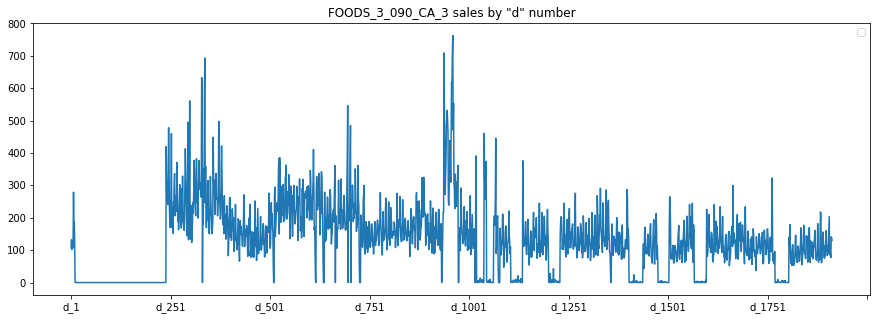

In [11]:
df_train.loc[df_train['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number')
plt.legend('')
plt.show()

## Trainデータ(evaluation)

In [46]:
df_train_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [45]:
df_train_evaluation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


### FOODSデータのプロット

In [47]:
df_train_evaluation_FOODS = df_train_evaluation.loc[df_train_evaluation['cat_id'] == 'FOODS']

In [58]:
pd_series_food = df_train_evaluation_FOODS.sum()
df_foods_sales = pd.DataFrame(pd_series_food)
df_foods_sales = df_foods_sales.filter(like='d_', axis=0)

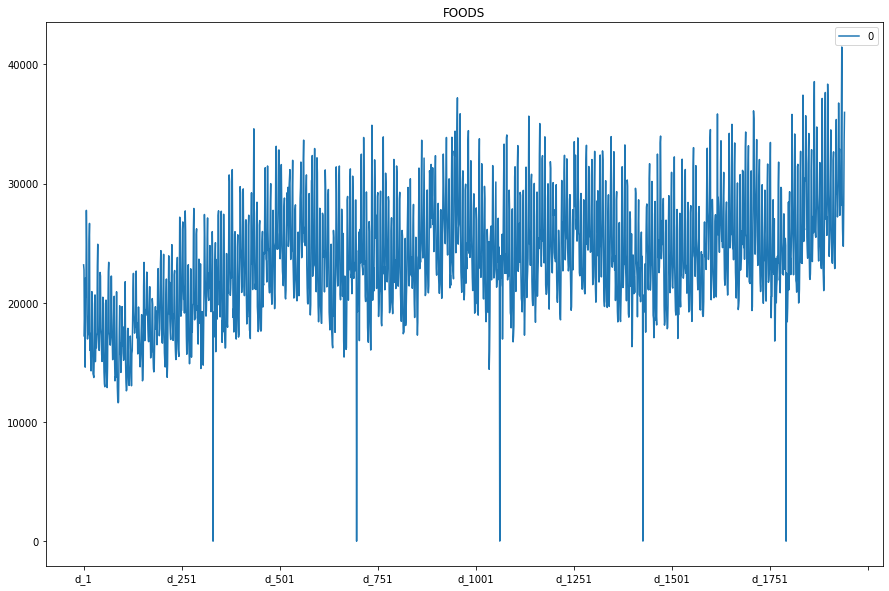

In [59]:
df_foods_sales.plot(figsize=(15, 10),
          title='FOODS')

In [60]:
# d_(number)で振られているindexをリセット
df_foods_sales.reset_index(inplace=True, drop=True)
df_foods_sales.rename(columns={0: 'sales'}, inplace=True)

In [61]:
df_foods_sales.head()

,sales
0,23178
1,22758
2,17174
3,18878
4,14603


### HOBBIESデータのプロット

In [62]:
df_train_evaluation_HOBBIES = df_train_evaluation.loc[df_train_evaluation['cat_id'] == 'HOBBIES']

In [63]:
pd_series_hobbies = df_train_evaluation_HOBBIES.sum()
df_hobbies_sales = pd.DataFrame(pd_series_hobbies)
df_hobbies_sales = df_hobbies_sales.filter(like='d_', axis=0)

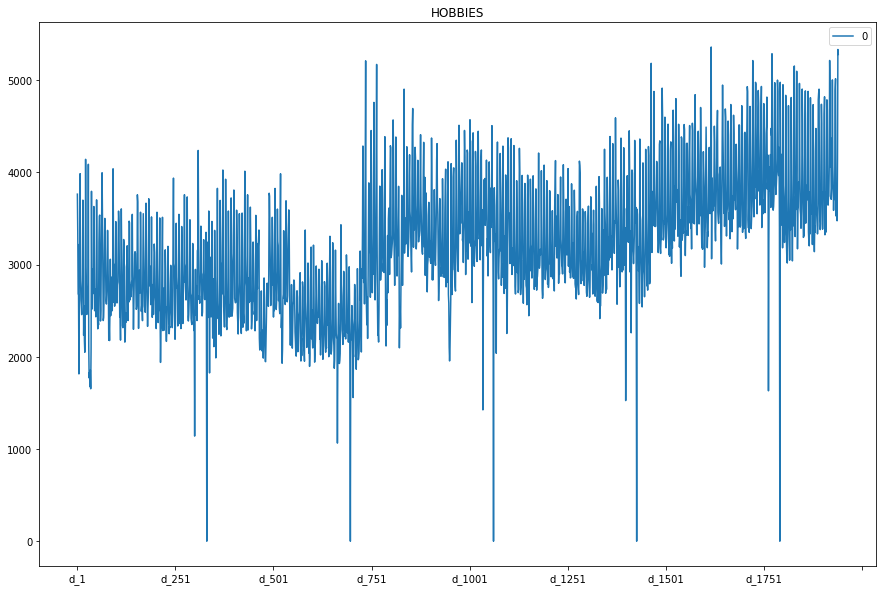

In [64]:
df_hobbies_sales.plot(figsize=(15, 10),
          title='HOBBIES')

In [65]:
# d_(number)で振られているindexをリセット
df_hobbies_sales.reset_index(inplace=True, drop=True)
df_hobbies_sales.rename(columns={0: 'sales'}, inplace=True)

In [66]:
df_hobbies_sales.head()

,sales
0,3764
1,3357
2,2682
3,2669
4,1814


### HOUSEHOLDデータのプロット

In [67]:
df_train_evaluation_HOUSEHOLD = df_train_evaluation.loc[df_train_evaluation['cat_id'] == 'HOUSEHOLD']

In [68]:
pd_series_household = df_train_evaluation_HOUSEHOLD.sum()
df_household_sales = pd.DataFrame(pd_series_household)
df_household_sales = df_household_sales.filter(like='d_', axis=0)

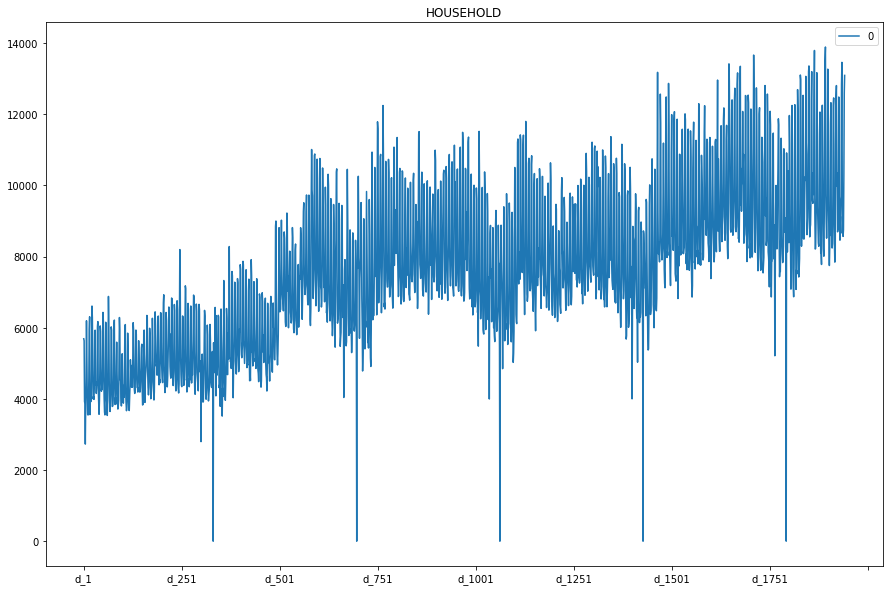

In [69]:
df_household_sales.plot(figsize=(15, 10),
          title='HOUSEHOLD')

In [70]:
# d_(number)で振られているindexをリセット
df_household_sales.reset_index(inplace=True, drop=True)
df_household_sales.rename(columns={0: 'sales'}, inplace=True)

In [71]:
df_household_sales.head()

,sales
0,5689
1,5634
2,3927
3,3865
4,2729


## Calendarデータ

In [20]:
df_calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [21]:
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

### Calendarデータの説明

| カラム名 | 説明 |
| - | - |
| date | 日付 |
| wm_yr_wk | 週のID（同じ週に同じIDを振る) |
| weekday | 曜日 |
| wday | 曜日を数字にしているもの |
| month | 月 |
| year | 年 |
| d | 日付ID |
| event_name_1 | イベント名1 |
| event_type_1 | イベントカテゴリ1 |
| event_name_2 | イベント名2 |
| event_type_2 | イベントカテゴリ2 |
| snap_CA | CAの低所得者に対する現金給付制度の有無 |
| snap_TX | TXの低所得者に対する現金給付制度の有無 |
| snap_WI | WIの低所得者に対する現金給付制度の有無 |

In [35]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int64         
 2   weekday       1969 non-null   object        
 3   wday          1969 non-null   int64         
 4   month         1969 non-null   int64         
 5   year          1969 non-null   int64         
 6   d             1969 non-null   object        
 7   event_name_1  162 non-null    object        
 8   event_type_1  162 non-null    object        
 9   event_name_2  5 non-null      object        
 10  event_type_2  5 non-null      object        
 11  snap_CA       1969 non-null   int64         
 12  snap_TX       1969 non-null   int64         
 13  snap_WI       1969 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(6)
memory usage: 215.5+ KB


In [36]:
df_calendar.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


In [37]:
print('-----event_name_1-----')
print(df_calendar['event_name_1'].value_counts())
print('-----event_type_1-----')
print(df_calendar['event_type_1'].value_counts())
print('-----event_name_2-----')
print(df_calendar['event_name_2'].value_counts())
print('-----event_type_2-----')
print(df_calendar['event_type_2'].value_counts())

-----event_name_1-----
PresidentsDay          6
NBAFinalsEnd           6
Purim End              6
Pesach End             6
MemorialDay            6
Ramadan starts         6
LentStart              6
Mother's day           6
ValentinesDay          6
NBAFinalsStart         6
LentWeek2              6
SuperBowl              6
StPatricksDay          6
Thanksgiving           5
Cinco De Mayo          5
Halloween              5
IndependenceDay        5
OrthodoxEaster         5
ColumbusDay            5
Easter                 5
Chanukah End           5
OrthodoxChristmas      5
LaborDay               5
Christmas              5
MartinLutherKingDay    5
EidAlAdha              5
VeteransDay            5
Eid al-Fitr            5
NewYear                5
Father's day           4
Name: event_name_1, dtype: int64
-----event_type_1-----
Religious    55
National     52
Cultural     37
Sporting     18
Name: event_type_1, dtype: int64
-----event_name_2-----
Father's day      2
Easter            1
Cinco De Ma

分かったこと
- 'wm-yr-wk'列は何週目かを表す
- 'event_name_2'、'event_type_2'は同じ日にイベントが２つ被った際に値が入る

## Priceデータ

In [113]:
df_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


### Priceデータの説明

| カラム名 | 説明 |
| - | - |
| store_id | 店のID |
| item_id | 商品のID |
| wm_yr_wk | 週のID(同じ週に同じIDを振る) |
| sell_price | 商品の金額 |

## Submissionデータ

In [ ]:
df_sbm

### Submissionデータの説明

| カラム名 | 説明 |
| - | - |
| id | 商品、店、データの種類を紐付けるID |
| F1〜F28 | 商品の売上個数 |

# 相関のプロット

## Calendarデータの分析

In [73]:
for i in df_calendar['event_name_1'].unique():
    if not pd.isnull(i):
        df_calendar[i] = 0

In [74]:
#イベントがある日に対応するカラムを366にする
for index, row in df_calendar.iterrows():
    if not pd.isnull(row['event_name_1']):
        df_calendar.at[index, row['event_name_1']] = 366

In [77]:
# イベントから遠ざかるにつれて、数値が下がっていくコード
for event_name in df_calendar['event_name_1'].unique():
    if not pd.isnull(event_name):
        ColumnName = event_name
        list_day = list()
        for index, row in df_calendar.iterrows():
            if row[ColumnName] == 0:
                list_day.append(index)
            else:
                for d_date in list_day:
                    df_calendar.at[d_date, [ColumnName]] = (366-(len(list_day)-list_day.index(d_date)))
                list_day = list()
        for d_date in list_day:
                df_calendar.at[d_date, [ColumnName]] = (366-(366-list_day.index(d_date)))

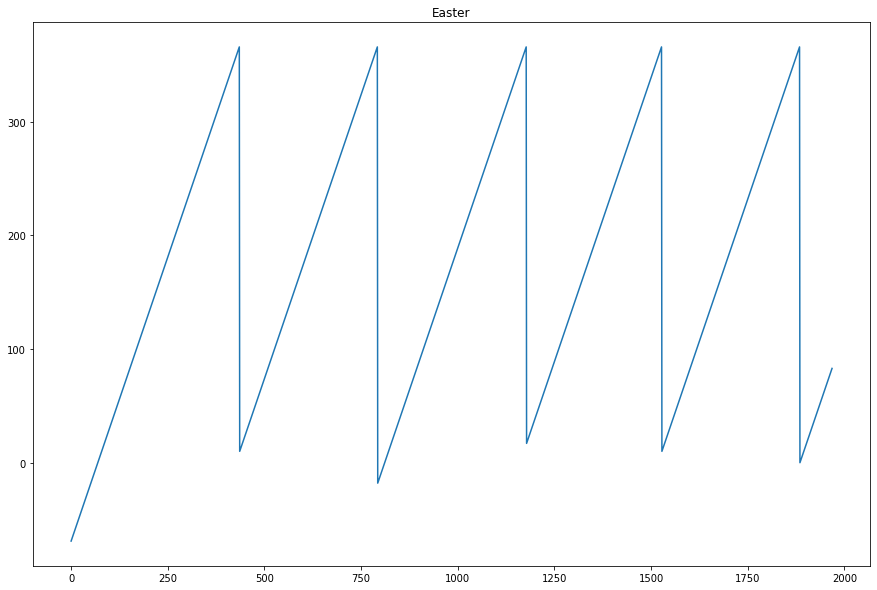

In [79]:
df_calendar["Easter"].plot(figsize=(15, 10),
          title='Easter')

### イベントと売上の相関をプロット

In [82]:
df_calendar_validation = df_calendar[:1941].copy()

#### FOODSの売上とイベントの相関

In [84]:
df_calendar_validation_foods = pd.concat([df_calendar_validation, df_foods_sales], axis=1)

In [88]:
df_calendar_validation_foods['sales'] = df_calendar_validation_foods['sales'].astype(int)
df_calendar_validation_foods.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,SuperBowl,ValentinesDay,PresidentsDay,LentStart,LentWeek2,StPatricksDay,Purim End,OrthodoxEaster,Pesach End,Cinco De Mayo,Mother's day,MemorialDay,NBAFinalsStart,NBAFinalsEnd,Father's day,IndependenceDay,Ramadan starts,Eid al-Fitr,LaborDay,ColumbusDay,Halloween,EidAlAdha,VeteransDay,Thanksgiving,Christmas,Chanukah End,NewYear,OrthodoxChristmas,MartinLutherKingDay,Easter,sales
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,358,350,343,327,320,319,316,281,279,270,267,245,244,232,225,210,182,152,147,112,91,84,80,67,36,33,29,23,14,-69,23178
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,359,351,344,328,321,320,317,282,280,271,268,246,245,233,226,211,183,153,148,113,92,85,81,68,37,34,30,24,15,-68,22758
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,360,352,345,329,322,321,318,283,281,272,269,247,246,234,227,212,184,154,149,114,93,86,82,69,38,35,31,25,16,-67,17174
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,361,353,346,330,323,322,319,284,282,273,270,248,247,235,228,213,185,155,150,115,94,87,83,70,39,36,32,26,17,-66,18878
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,362,354,347,331,324,323,320,285,283,274,271,249,248,236,229,214,186,156,151,116,95,88,84,71,40,37,33,27,18,-65,14603


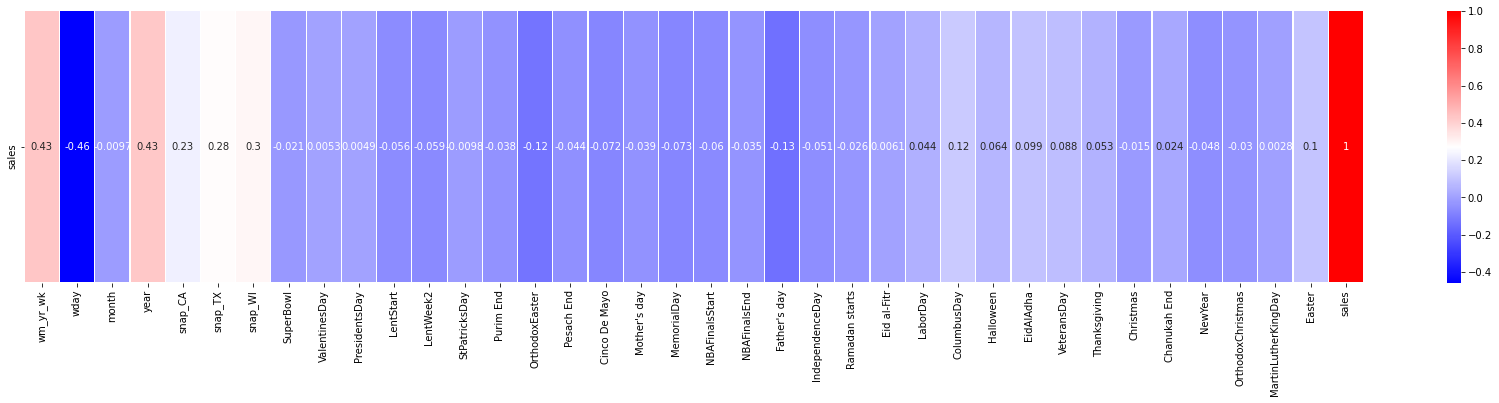

In [106]:
plt.figure(figsize = (30, 5))
sns.heatmap(df_calendar_validation_foods.corr()[-1:],annot=True,cmap='bwr',linewidths=0.2) 
fig=plt.gcf()
plt.show()

#### HOBBIESの売上とイベントの相関

In [107]:
df_calendar_validation_hobbies = pd.concat([df_calendar_validation, df_hobbies_sales], axis=1)

In [108]:
df_calendar_validation_hobbies['sales'] = df_calendar_validation_hobbies['sales'].astype(int)
df_calendar_validation_hobbies.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,SuperBowl,ValentinesDay,PresidentsDay,LentStart,LentWeek2,StPatricksDay,Purim End,OrthodoxEaster,Pesach End,Cinco De Mayo,Mother's day,MemorialDay,NBAFinalsStart,NBAFinalsEnd,Father's day,IndependenceDay,Ramadan starts,Eid al-Fitr,LaborDay,ColumbusDay,Halloween,EidAlAdha,VeteransDay,Thanksgiving,Christmas,Chanukah End,NewYear,OrthodoxChristmas,MartinLutherKingDay,Easter,sales
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,358,350,343,327,320,319,316,281,279,270,267,245,244,232,225,210,182,152,147,112,91,84,80,67,36,33,29,23,14,-69,3764
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,359,351,344,328,321,320,317,282,280,271,268,246,245,233,226,211,183,153,148,113,92,85,81,68,37,34,30,24,15,-68,3357
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,360,352,345,329,322,321,318,283,281,272,269,247,246,234,227,212,184,154,149,114,93,86,82,69,38,35,31,25,16,-67,2682
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,361,353,346,330,323,322,319,284,282,273,270,248,247,235,228,213,185,155,150,115,94,87,83,70,39,36,32,26,17,-66,2669
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,362,354,347,331,324,323,320,285,283,274,271,249,248,236,229,214,186,156,151,116,95,88,84,71,40,37,33,27,18,-65,1814


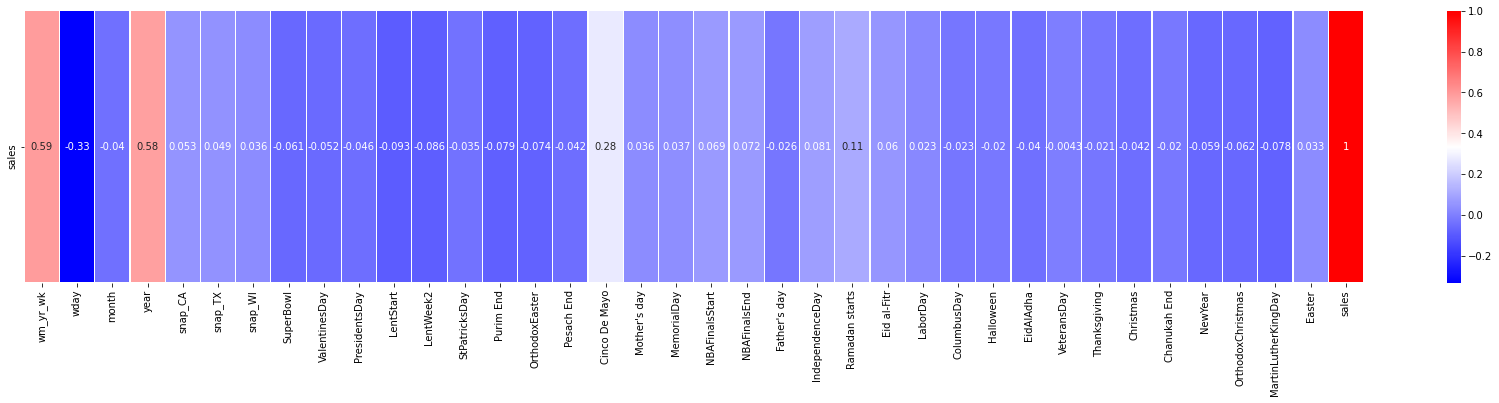

In [109]:
plt.figure(figsize = (30, 5))
sns.heatmap(df_calendar_validation_hobbies.corr()[-1:],annot=True,cmap='bwr',linewidths=0.2) 
fig=plt.gcf()
plt.show()

#### HOUSEHOLDの売上とイベントの相関

In [110]:
df_calendar_validation_household = pd.concat([df_calendar_validation, df_household_sales], axis=1)

In [111]:
df_calendar_validation_household['sales'] = df_calendar_validation_household['sales'].astype(int)
df_calendar_validation_household.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,SuperBowl,ValentinesDay,PresidentsDay,LentStart,LentWeek2,StPatricksDay,Purim End,OrthodoxEaster,Pesach End,Cinco De Mayo,Mother's day,MemorialDay,NBAFinalsStart,NBAFinalsEnd,Father's day,IndependenceDay,Ramadan starts,Eid al-Fitr,LaborDay,ColumbusDay,Halloween,EidAlAdha,VeteransDay,Thanksgiving,Christmas,Chanukah End,NewYear,OrthodoxChristmas,MartinLutherKingDay,Easter,sales
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,358,350,343,327,320,319,316,281,279,270,267,245,244,232,225,210,182,152,147,112,91,84,80,67,36,33,29,23,14,-69,5689
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,359,351,344,328,321,320,317,282,280,271,268,246,245,233,226,211,183,153,148,113,92,85,81,68,37,34,30,24,15,-68,5634
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,360,352,345,329,322,321,318,283,281,272,269,247,246,234,227,212,184,154,149,114,93,86,82,69,38,35,31,25,16,-67,3927
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,361,353,346,330,323,322,319,284,282,273,270,248,247,235,228,213,185,155,150,115,94,87,83,70,39,36,32,26,17,-66,3865
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,362,354,347,331,324,323,320,285,283,274,271,249,248,236,229,214,186,156,151,116,95,88,84,71,40,37,33,27,18,-65,2729


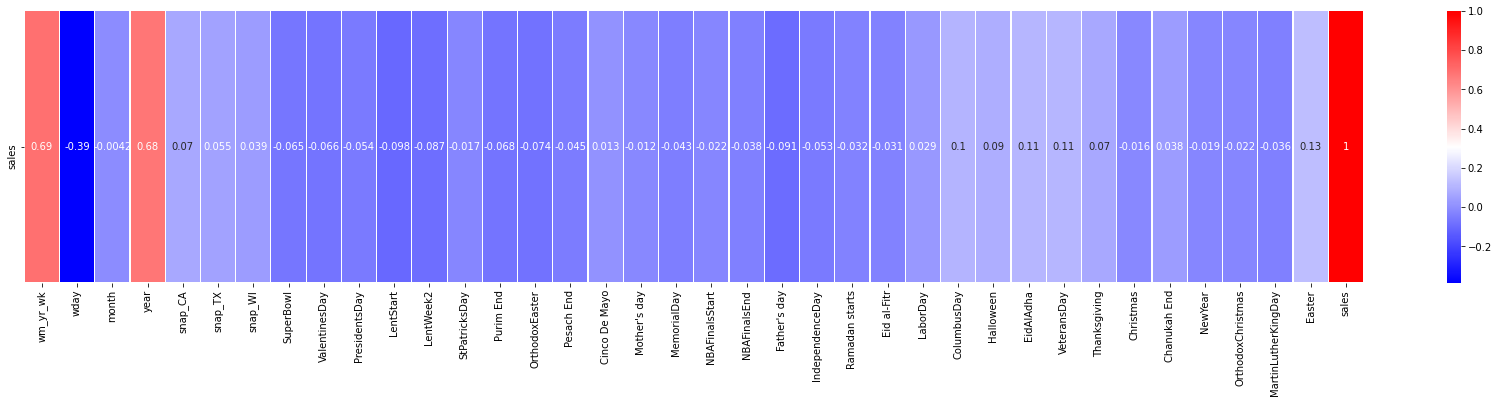

In [112]:
plt.figure(figsize = (30, 5))
sns.heatmap(df_calendar_validation_household.corr()[-1:],annot=True,cmap='bwr',linewidths=0.2) 
fig=plt.gcf()
plt.show()